Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import SVG

Set global variables

In [2]:
PATH_IN = '../data/output/'

SCENARIO = 'testing'
YEAR = '2024'

In [3]:
SVG(filename='../data/misc/topology/230815_topology.svg')

Read output data

In [4]:
if SCENARIO == 'testing':
    path_input = PATH_IN + SCENARIO + '/'
else:
    path_input = PATH_IN + SCENARIO + '/' + YEAR + '/'

output_df = pd.read_csv(path_input + 'output_time_series.csv', index_col=0)
output_df.index.name = 't'
print(output_df.columns)

Index(['power_price', 'gas_price', 'bhkw_bin', 'storage_charge_bin',
       'storage_discharge_bin', 'net_feeding_bin', 'net_supplying_bin',
       'bhkw_gas', 'bhkw_power', 'bhkw_heat', 'net_power', 'storage_power',
       'storage_energy', 'bhkw_con_1_power', 'bhkw_con_2_power',
       'storage_con_3_power', 'net_con_4_power'],
      dtype='object')


Prepare class for Assets

In [5]:
class Asset:
    """Class for evaluating asset output data."""

    def __init__(self, asset_id) -> None:
        self.id: str = asset_id
        self.postprocess_data: dict = {}
        self.asset_data: pd.DataFrame = pd.DataFrame()

    def get_asset_data(self, output_df: pd.DataFrame):
        """ Gets all columns from output_df with the asset id in it. """

        for column_name in output_df.columns:
            if self.id in column_name:
                self.asset_data[column_name] = output_df[column_name]
        
        if self.asset_data.empty:
            print(f'Found no data for {self.id}.')
    
    def calc_costs(self, output_df: pd.DataFrame):
        """ Calculates costs for the asset."""

        for column in self.asset_data.columns:
            if '_gas' in column:
                self.asset_data[f'{self.id}_gas_cost'] = (
                    self.asset_data[f'{self.id}_gas'] 
                    * output_df['gas_price']
                )
                self.asset_data[f'{self.id}_gas_cost'].fillna(0, inplace=True)

            elif '_power' in column:
                self.asset_data[f'{self.id}_power_cost'] = (
                    self.asset_data[f'{self.id}_power'].where(
                    self.asset_data[f'{self.id}_power'] <= 0                    
                    )
                    * output_df['power_price']
                )
                self.asset_data[f'{self.id}_power_cost'].fillna(0, inplace=True)

                self.asset_data[f'{self.id}_power_revenue'] = (
                    self.asset_data[f'{self.id}_power'].where(
                    self.asset_data[f'{self.id}_power'] >= 0                    
                    )
                    * output_df['power_price']
                )
                self.asset_data[f'{self.id}_power_revenue'].fillna(0, inplace=True)

    def calc_postprocess_data(self):
        """ Calculates the sum of all columns in the asset data."""

        for column in self.asset_data.columns:
            column_sum = self.asset_data[column].sum()
            key_name = column.replace((self.id + '_'), '')
            self.postprocess_data[key_name] = column_sum

Calculate overview data for assets

In [6]:
assets_dict = {}
for asset in ['bhkw', 'storage', 'net', 'price']:
    assets_dict[asset] = Asset(asset)
    assets_dict[asset].get_asset_data(output_df)
    assets_dict[asset].calc_costs(output_df)
    assets_dict[asset].calc_postprocess_data()


postprocess_dict = {}
for asset in assets_dict.keys():
    postprocess_dict[asset] = assets_dict[asset].postprocess_data

print(postprocess_dict)

df = pd.DataFrame(postprocess_dict)
print(df)

{'bhkw': {'bin': 24.0, 'gas': 73.80000000000001, 'power': 30.0, 'heat': 30.0, 'con_1_power': 10.0, 'con_2_power': 20.0, 'gas_cost': 1289.1999999999998, 'power_cost': 0.0, 'power_revenue': 1004.0}, 'storage': {'charge_bin': 11.0, 'discharge_bin': 13.0, 'power': 0.0, 'energy': 43.0, 'con_3_power': 10.0, 'power_cost': -155.0, 'power_revenue': 437.0}, 'net': {'feeding_bin': 24.0, 'supplying_bin': 0.0, 'power': 30.0, 'con_4_power': 0.0, 'power_cost': 0.0, 'power_revenue': 1286.0}, 'price': {'power_price': 692.0, 'gas_price': 420.0}}
                 bhkw  storage     net  price
bin              24.0      NaN     NaN    NaN
gas              73.8      NaN     NaN    NaN
power            30.0      0.0    30.0    NaN
heat             30.0      NaN     NaN    NaN
con_1_power      10.0      NaN     NaN    NaN
con_2_power      20.0      NaN     NaN    NaN
gas_cost       1289.2      NaN     NaN    NaN
power_cost        0.0   -155.0     0.0    NaN
power_revenue  1004.0    437.0  1286.0    NaN
charge

Define function for checking the objectiv value

In [7]:
def check_objective_value(output_dict):
    result = (output_dict['bhkw']['gas_cost']
              - output_dict['net']['power_cost'] 
              - output_dict['net']['power_revenue']
              )
    obj_value = (pd.read_csv(path_input + 'results.csv', index_col=0)).iloc[0].values[0]
    
    if result == obj_value:
        print('Objective value and calculated value are the same.')
        print(f'{obj_value} == {result}')
    
    else:
        print('Objective value and calculated value are not identical!')
        print(f'{obj_value} =/= {result}')

In [8]:
check_objective_value(postprocess_dict)

Objective value and calculated value are not identical!
3.200000000000045 =/= 3.199999999999818


Create Plots

t
1      40.0
2      80.0
3     120.0
4     160.0
5     113.8
6      10.6
7     -53.0
8     -43.0
9     -78.0
10    -33.0
11     12.0
12     57.0
13    102.0
14    147.0
15    132.0
16     97.0
17     33.4
18    -63.2
19   -126.8
20   -111.8
21    -86.8
22    -56.8
23    -11.8
24      3.2
dtype: float64
3.1999999999999744


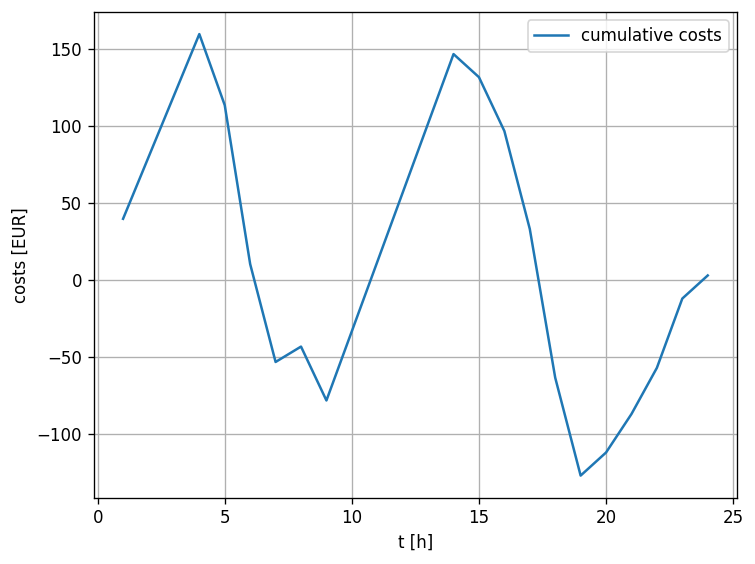

In [9]:
costs = (assets_dict['bhkw'].asset_data['bhkw_gas_cost']
         - assets_dict['net'].asset_data['net_power_cost']
         - assets_dict['net'].asset_data['net_power_revenue']
)
print(costs.cumsum())
print(sum(costs))
plt.figure(dpi=120)
costs.cumsum().plot(label='cumulative costs')
plt.xlabel('t [h]')
plt.ylabel('costs [EUR]')
plt.grid()
plt.legend()
plt.tight_layout()